<div style="text-align: center;"> <h1> FURIA Know Your Fan (Individual)</h1> </div>

### Configurações Iniciais

#### Importação Chave API (Arquivo .env)

In [1]:
from dotenv import load_dotenv
import os

from oauthlib.oauth2 import BearerToken

# Carregar variáveis do .env
load_dotenv()

chave_api = os.getenv('API_KEY')

### Coleta e Tratamento de Dados

#### Coleta de Dados (Formulário)

In [1]:
import http.server
import socketserver
import webbrowser
import json
import uuid
import os
import hashlib
import threading
import base64
from datetime import datetime
from cryptography.fernet import Fernet

PORT = 8080
DATA_DIR = "form_data"
KEY_FILE = "rg_encryption.key"

# Carrega ou gera a chave de criptografia
if not os.path.exists(KEY_FILE):
    key = Fernet.generate_key()
    with open(KEY_FILE, 'wb') as kf:
        kf.write(key)
else:
    with open(KEY_FILE, 'rb') as kf:
        key = kf.read()
fernet = Fernet(key)

class MyHandler(http.server.SimpleHTTPRequestHandler):
    def do_GET(self):
        # silencia favicon.ico
        if self.path == '/favicon.ico':
            self.send_response(204)
            self.end_headers()
            return
        return super().do_GET()

    def do_POST(self):
        # aceita tanto /submit quanto /Form/form.html
        if self.path not in ('/submit', '/Form/form.html'):
            return super().do_GET()

        # Lê e desserializa o JSON
        content_length = int(self.headers.get('Content-Length', 0))
        raw_body = self.rfile.read(content_length).decode('utf-8')
        try:
            dados = json.loads(raw_body)
        except json.JSONDecodeError:
            return self.send_error(400, "Bad Request: JSON inválido")

        # --- processa CPF, imagens, timestamp ---
        if 'cpf' in dados and dados['cpf']:
            dados['cpf'] = hashlib.sha256(dados['cpf'].encode()).hexdigest()
        rg_b64 = dados.pop('rgImagem_base64', None)
        selfie_b64 = dados.pop('selfieImagem_base64', None)
        dados['submitted_at'] = datetime.utcnow().isoformat() + 'Z'

        # gera ID e pasta
        user_id = str(uuid.uuid4())
        os.makedirs(DATA_DIR, exist_ok=True)

        # criptografa RG
        if rg_b64:
            try:
                rg_bytes = base64.b64decode(rg_b64)
                encrypted = fernet.encrypt(rg_bytes)
                enc_fn = f"{user_id}_rg.enc"
                with open(os.path.join(DATA_DIR, enc_fn), 'wb') as ef:
                    ef.write(encrypted)
                dados['rgImagem_encrypted'] = enc_fn
            except Exception as e:
                print("Erro RG:", e)

        # salva selfie
        if selfie_b64:
            try:
                selfie_bytes = base64.b64decode(selfie_b64)
                sf_fn = f"{user_id}_selfie.png"
                with open(os.path.join(DATA_DIR, sf_fn), 'wb') as imgf:
                    imgf.write(selfie_bytes)
                dados['selfieImagem_file'] = sf_fn
            except Exception as e:
                print("Erro Selfie:", e)

        # salva metadados atômico
        meta_tmp = os.path.join(DATA_DIR, f"{user_id}.json.tmp")
        meta_path = os.path.join(DATA_DIR, f"{user_id}.json")
        try:
            with open(meta_tmp, 'w', encoding='utf-8') as f:
                json.dump(dados, f, indent=4, ensure_ascii=False)
            os.replace(meta_tmp, meta_path)
        except Exception as e:
            print("Erro JSON:", e)
            return self.send_error(500, "Internal Server Error")

        # salva last_user_id.json
        try:
            with open(os.path.join(DATA_DIR, 'last_user_id.json'), 'w', encoding='utf-8') as f:
                json.dump({'last_user_id': user_id}, f, indent=4, ensure_ascii=False)
        except Exception as e:
            print("Erro last_user_id:", e)

        # envia resposta
        resp = {'status':'success','message':'Dados recebidos!','user_id':user_id}
        self.send_response(200)
        self.send_header('Content-Type','application/json')
        self.end_headers()
        self.wfile.write(json.dumps(resp).encode())

        # encerra imediatamente (não bloqueante)
        threading.Thread(target=self.server.shutdown, daemon=True).start()


class StoppableTCPServer(socketserver.TCPServer):
    allow_reuse_address = True


def run_server():
    with StoppableTCPServer(("", PORT), MyHandler) as httpd:
        print(f"Servidor rodando em http://localhost:{PORT}")
        webbrowser.open(f"http://localhost:{PORT}/Form/form.html")
        try:
            httpd.serve_forever()
        except KeyboardInterrupt:
            print("Interrompido pelo usuário")
        finally:
            httpd.server_close()
            print("Servidor finalizado")


if __name__ == "__main__":
    run_server()


Servidor rodando em http://localhost:8080


127.0.0.1 - - [01/May/2025 11:42:41] "GET /Form/form.html HTTP/1.1" 200 -


Servidor finalizado


C:\Users\leomo\AppData\Local\Temp\ipykernel_16736\3840492482.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dados['submitted_at'] = datetime.utcnow().isoformat() + 'Z'
127.0.0.1 - - [01/May/2025 11:43:03] "POST /submit HTTP/1.1" 200 -


<div style="text-align: center;"> <h3>Validação de Identidade com Abordagem de IA</h3> </div>



##### Instale as bibliotecas necessárias

- pytesseract (requer Tesseract OCR engine instalado separadamente)
 
- Pillow (dependência do pytesseract)
 
- face_recognition (requer dlib, pode ser complexo instalar em alguns sistemas)

- ipywidgets (para o widget de upload)

<br>

```pip install pytesseract Pillow face_recognition ipywidgets ```


<div style="text-align: center;"> <h4>OCR, Extração e Comparação de Dados Textuais</h4> </div>


Definimos uma função para realizar o OCR na imagem do documento completo, extrair o texto, tentar encontrar Nome e CPF e compará-los com dados fornecidos (vamos simular esses dados fornecidos para o exemplo).

In [ ]:
%pip install tesseract pytesseract

#### Validação Nome e Naturalidade (OCR)

In [4]:
import os
import io
import json
import re
import hashlib

from PIL import Image
import numpy as np
import cv2
import pytesseract
from cryptography.fernet import Fernet

# ————————— Configurações Tesseract —————————
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
TESS_CONF_FULL   = "--oem 3 --psm 3"
TESS_CONF_DIGITS = "--oem 3 --psm 3 -c tessedit_char_whitelist=0123456789"
TESS_CONF_MRZ    = "--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ<"

DATA_DIR = "form_data"
KEY_FILE = "rg_encryption.key"

# ————————— Carrega chave e dados do JSON mais recente —————————
fernet = Fernet(open(KEY_FILE, "rb").read())
json_files = sorted(
    [f for f in os.listdir(DATA_DIR) if f.endswith(".json") and f != 'last_user_id.json'],
    key=lambda fn: os.path.getmtime(os.path.join(DATA_DIR, fn)),
    reverse=True
)
if not json_files:
    raise FileNotFoundError(f"No JSON files found in {DATA_DIR}")

latest_json = json_files[0]
user_id = os.path.splitext(latest_json)[0]
form_data = json.load(open(os.path.join(DATA_DIR, latest_json), encoding="utf-8"))
provided_name = form_data.get("nome", "")
cpf_hash = form_data.get("cpf", "")

# ————————— Decrypt + carrega imagem em alta resolução (×2) —————————
encrypted_fn = form_data.get("rgImagem_encrypted")
if encrypted_fn:
    enc_path = os.path.join(DATA_DIR, encrypted_fn)
    try:
        raw_bytes = fernet.decrypt(open(enc_path, "rb").read())
        pil = Image.open(io.BytesIO(raw_bytes)).convert("RGB")
        pil = pil.resize((pil.width * 2, pil.height * 2), Image.LANCZOS)
        img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Erro ao descriptografar '{encrypted_fn}': {e}")
        img = None
else:
    print("Aviso: 'rgImagem_encrypted' not found in form_data")
    img = None

# ————————— Pré-processamento e OCR —————————
if img is not None:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)
    _, prep = cv2.threshold(cl, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    full_ocr_text = pytesseract.image_to_string(prep, config=TESS_CONF_FULL, lang="por+eng")
else:
    full_ocr_text = ""
    print("Skipping OCR: no image available.")

# ————————— Função de validação de CPF —————————
def valida_cpf(c: str) -> bool:
    if len(c) != 11 or c == c[0]*11:
        return False
    s1 = sum(int(c[i])*(10-i) for i in range(9))
    d1 = ((s1*10) % 11) % 10
    s2 = sum(int(c[i])*(11-i) for i in range(10))
    d2 = ((s2*10) % 11) % 10
    return c[-2:] == f"{d1}{d2}"

# ————————— Extrai Nome via MRZ —————————
name = None
name_ocr_raw = None
mrz_lines = [L.strip() for L in full_ocr_text.splitlines() if "<<" in L]
if mrz_lines:
    mrz = mrz_lines[-1]
    parts = mrz.split("<<")
    if len(parts) >= 2:
        surname = parts[0].title()
        given_list = [p for p in parts[1].split("<") if p]
        # Reverse given_list to correct order of given names
        given_reversed = list(reversed(given_list))
        name = " ".join(p.title() for p in given_reversed + [surname])
        name_ocr_raw = mrz

# Normalize and compare
def normalize(n: str) -> str:
    t = re.sub(r'\b(?:de|da|dos|das|do)\b','', n, flags=re.IGNORECASE)
    return re.sub(r'\s+','', t).lower()

name_match = bool(name and normalize(name) == normalize(provided_name))
if name_match:
    name = provided_name

# ————————— Extração da Naturalidade —————————
naturalidade = None
naturalidade_match = False
m = re.search(
    r'(?:Naturalidade|Natural de|Natural)\s*[:\-]?\s*([\wÀ-ú\s]+)[-/]?\s*([A-Za-z]{2})',
    full_ocr_text,
    flags=re.IGNORECASE
)
if m:
    cidade = m.group(1).strip().title()
    estado = m.group(2).strip().upper()
    naturalidade = f"{cidade} - {estado}"
else:
    f2 = re.search(r'ESTADO DE\s+([\wÀ-ú]+)\s+([A-Za-z]{2})', full_ocr_text, flags=re.IGNORECASE)
    if f2:
        cidade = f2.group(1).strip().title()
        estado = f2.group(2).strip().upper()
        naturalidade = f"{cidade} - {estado}"

expected_city = form_data.get("endereco", "").strip().lower()
if naturalidade:
    naturalidade_match = (naturalidade.split(" - ")[0].strip().lower() == expected_city)

# ————————— Atualiza e salva o JSON —————————
form_data.update({
    "naturalidade_extraida": naturalidade,
    "naturalidade_match": naturalidade_match,
    "name_match": name_match
})
with open(os.path.join(DATA_DIR, latest_json), "w", encoding="utf-8") as f:
    json.dump(form_data, f, ensure_ascii=False, indent=4)

# ————————— Exibe resultado —————————
result = {
    "full_ocr_text": full_ocr_text,
    "name": name,
    "name_ocr_raw": name_ocr_raw,
    "name_match": name_match,
    "naturalidade": naturalidade,
    "naturalidade_match": naturalidade_match
}
print(json.dumps(result, indent=4, ensure_ascii=False))


{
    "full_ocr_text": "Y REPÚBLICA FEDERATIVA DO BRASIL\n1 MINISTERIO DA JUSTIÇA\nESTADO DE UTOPIA\n\nFERNANDA: ” |\nDE CARVALHO DA: SILVA\n\nSEXO1'SEX\nwcowLsicg Moe 7\n- moemscmrsosmn ot\n\n12.07 1975: -\n\nNOMERO RIC 110.8\" DATADE VRLOADE / EXPE\n0000000002-7 a4 10 2015:\n\n& 9000000002-7\n\nUTOPIA = UT CRAVAIETIFLEAZI NOTE”\n- ROIUF :\nSe 201224567 (UT -\n\n“ABI234567890\n\nTEM FE PUBLICA E VALIDADE EM TODO TERRITÓRIO NACIONAL - DECRETO N° 7.168 DE 05/05/2010\n\nIDUTOOO000000027 2<<<<<<<<<<<<<\n7507123F1510212UTO0<<<<<<<<<<<2\nSILVA<<CARVALHO<FERNANDA<<<<<<\n",
    "name": "Fernanda de Carvalho da Silva",
    "name_ocr_raw": "SILVA<<CARVALHO<FERNANDA<<<<<<",
    "name_match": true,
    "naturalidade": "Utopia - FE",
    "naturalidade_match": true
}


#### Reconhecimento e Comparação Facial

Ao baixar o tesseract, lembrar de baixar a lingua portuguesa e adicionar na pasta -> C:\Program Files\Tesseract-OCR\tessdata

"por.traineddata"

In [ ]:
%pip install opencv-python


In [5]:
import json
import io
from pathlib import Path
from typing import Any, Dict, Optional

import numpy as np
import cv2
from PIL import Image
from cryptography.fernet import Fernet

# Constants
DATA_DIR = Path("form_data")
KEY_FILE = Path("rg_encryption.key")
CASCADE_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
FACE_SIZE = (150, 150)
DISTANCE_THRESHOLD = 60.0  # adjustable threshold for face match

def load_fernet_key(key_path: Path) -> Fernet:
    """
    Load Fernet encryption key from file.
    """
    with key_path.open("rb") as f:
        key = f.read()
    return Fernet(key)


def load_latest_form(data_dir: Path) -> tuple[Dict[str, Any], Path]:
    """
    Load the most recent JSON form from data_dir, returning the data and its file path.
    """
    json_files = sorted(data_dir.glob("*.json"), key=lambda f: f.stat().st_mtime, reverse=True)
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in {data_dir}")
    latest = json_files[0]
    with latest.open("r", encoding="utf-8") as f:
        data = json.load(f)
    # retornamos também o caminho do arquivo JSON para permitir regravação
    return data, latest


def decrypt_image(encrypted_filename: str, fernet: Fernet, data_dir: Path) -> Image.Image:
    """
    Decrypt an image file and return a PIL Image.
    """
    encrypted_path = data_dir / encrypted_filename
    if not encrypted_path.exists():
        raise FileNotFoundError(f"Encrypted file not found: {encrypted_path}")
    data = fernet.decrypt(encrypted_path.read_bytes())
    return Image.open(io.BytesIO(data))


def load_plain_image(filename: str, data_dir: Path) -> Image.Image:
    """
    Load a non-encrypted image from disk as PIL Image.
    """
    img_path = data_dir / filename
    if not img_path.exists():
        raise FileNotFoundError(f"Image file not found: {img_path}")
    return Image.open(img_path)


def pil_to_bgr(img: Image.Image) -> np.ndarray:
    """
    Convert PIL Image to OpenCV BGR numpy array.
    """
    return cv2.cvtColor(np.array(img.convert("RGB")), cv2.COLOR_RGB2BGR)


def detect_face(image_bgr: np.ndarray, cascade: cv2.CascadeClassifier) -> Optional[np.ndarray]:
    """
    Detect the first face in a BGR image, crop and resize it.
    Returns the grayscale face ROI or None.
    """
    faces = cascade.detectMultiScale(image_bgr, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]
    face = image_bgr[y:y+h, x:x+w]
    face_resized = cv2.resize(face, FACE_SIZE)
    return cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)


def compare_faces(gray1: np.ndarray, gray2: np.ndarray) -> float:
    """
    Compute mean absolute difference between two grayscale face images.
    """
    diff = cv2.absdiff(gray1, gray2)
    return float(np.mean(diff))


def perform_face_comparison_opencv(
    img1_pil: Image.Image, img2_pil: Image.Image, threshold: float = DISTANCE_THRESHOLD
) -> Dict[str, Any]:
    """
    Compare two PIL images containing faces using OpenCV Haar cascades.
    Returns a dict with match result, distance, and status.
    """
    results: Dict[str, Any] = {
        'face_match': False,
        'distance': None,
        'success': False,
        'message': ''
    }
    try:
        img1_bgr = pil_to_bgr(img1_pil)
        img2_bgr = pil_to_bgr(img2_pil)

        cascade = cv2.CascadeClassifier(CASCADE_PATH)
        if cascade.empty():
            raise RuntimeError(f"Failed to load cascade classifier at {CASCADE_PATH}")

        face1 = detect_face(img1_bgr, cascade)
        face2 = detect_face(img2_bgr, cascade)

        if face1 is None or face2 is None:
            results['message'] = "No face detected in one or both images."
            return results

        distance = compare_faces(face1, face2)
        results['distance'] = float(distance)
        results['face_match'] = bool(distance < threshold)
        results['success'] = True
        results['message'] = "Comparison successful with OpenCV."
    except Exception as e:
        results['message'] = f"Error during face comparison: {e}"
    return results


if __name__ == "__main__":
    # Initialize
    fernet = load_fernet_key(KEY_FILE)
    form_data, form_path = load_latest_form(DATA_DIR)

    # Decrypt RG image
    encrypted_rg = form_data.get("rgImagem_encrypted")
    img_doc = decrypt_image(encrypted_rg, fernet, DATA_DIR)

    # Load selfie (not encrypted)
    selfie_filename = form_data.get("selfieImagem_file")
    img_selfie = load_plain_image(selfie_filename, DATA_DIR)

    # Run comparison
    result = perform_face_comparison_opencv(img_doc, img_selfie)

    # Add result index to form data
    form_data['rosto_correto_indice'] = 1 if result.get('face_match') else 0
    form_data['face_match'] = result.get('face_match')
    form_data['face_distance'] = result.get('distance')

    # Save updated JSON back to file
    with form_path.open('w', encoding='utf-8') as f:
        json.dump(form_data, f, indent=4, ensure_ascii=False)

    # Print JSON-safe result
    print(json.dumps(result, indent=4, ensure_ascii=False))


{
    "face_match": true,
    "distance": 18.172044444444445,
    "success": true,
    "message": "Comparison successful with OpenCV."
}


<div style="text-align: center;"> <h3>Integração com Redes Sociais (Simulada)</h3> </div>


#### Twitter (usuário individual) - Chamada API

In [ ]:
import os
import json
import tweepy
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

chave_api = os.getenv("twitter_api")

# ————————— Configurações e autenticação —————————
BEARER_TOKEN = chave_api  # Substitua pelo seu Bearer Token

client = tweepy.Client(bearer_token=BEARER_TOKEN)
# ————————— Carrega JSON com dados do usuário —————————
DATA_DIR = 'form_data'
json_files = sorted([
    f for f in os.listdir(DATA_DIR) if f.endswith('.json')
], key=lambda fn: os.path.getmtime(os.path.join(DATA_DIR, fn)), reverse=True)
json_path = os.path.join(DATA_DIR, json_files[0])
form_data = json.load(open(json_path, encoding='utf-8'))

# Extrai o username (sem o @) que está salvo no JSON, ex: "@teste" ou "teste"
raw_handle = form_data.get('twitter', '').strip()
twitter_handle = raw_handle.lstrip('@')
if not twitter_handle:
    raise ValueError('Nenhum handle de Twitter encontrado no JSON')

# ————————— Termos específicos a buscar —————————
TERMS = [
    'Fallen', 'KSCERATO', 'yuurih', 'molodoy', 'skullz', 'chelo',
    'fNb', 'Goot', 'Envy', 'Trigo', 'RedBert', 'Fntzy', 'R4re',
    'Handyy', 'KDS', 'yanxnz', 'Lostt', 'nzr', 'Khalil', 'havoc',
    'xand', 'mwzera', 'Xeratricky', 'Pandxrz', 'HisWattson',
    '#FURIACS', '#FURIAR6', '#FURIAFC', '#DIADEFURIA'
]

# Monta query para buscar tweets do usuário contendo qualquer termo
query_terms = ' OR '.join(f'"{t}"' for t in TERMS)
query = f'from:{twitter_handle} ({query_terms}) -is:retweet lang:pt'

# ————————— Busca tweets —————————
max_results = 15  # até 100
response = client.search_recent_tweets(
    query=query,
    max_results=max_results,
    tweet_fields=['id', 'text', 'created_at', 'lang', 'source'],
    expansions=['author_id'],
    user_fields=['username', 'name', 'description', 'location']
)

# ————————— Monta resultados para salvar —————————
tweets_data = []
if response.data:
    users_index = {u['id']: u for u in response.includes.get('users', [])}
    for tweet in response.data:
        info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': str(tweet.created_at),
            'lang': tweet.lang,
            'source': tweet.source,
            'author': {
                'id': tweet.author_id,
                'username': users_index[tweet.author_id].username,
                'name': users_index[tweet.author_id].name,
            }
        }
        tweets_data.append(info)

# ————————— Salva em JSON —————————
output_path = os.path.join(DATA_DIR, f'tweets_User.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(tweets_data, f, ensure_ascii=False, indent=4)

print(f"Salvos {len(tweets_data)} tweets em {output_path}")



<div style="text-align: center;"> <h3>Enriquecimento de Perfil com Dados Sociais e Multimídia</h3> </div>

- **Análise de Comentários:** Para integrar comentários prévios do usuário no YouTube, Reddit e Twitter, incluir blocos que consumam APIs ou dados locais de análise anterior (supondo que existam). Usar `google-api-python-client` para extrair comentários de vídeos de e-sports do YouTube, `PRAW` para posts/comentários no Reddit, e `tweepy` ou dados simulados para tweets.  
- **Processamento de Linguagem Natural:** Aplicar NLP para entender o perfil do usuário: usar bibliotecas como `transformers` ou `spaCy` para classificar sentimento, identificar tópicos ou palavras-chave frequentes nesses comentários. Por exemplo, gerar um gráfico de palavras-chave mais mencionadas em e-sports, ou uma análise de sentimento geral sobre jogos específicos.  
- **Integração de Informações:** Combinar esses insights com os interesses declarados pelo usuário. Exibir visualmente (via `matplotlib` ou `seaborn`) uma nuvem de palavras ou gráfico que mostre as categorias de e-sports mais relevantes para o perfil (baseado em interesses + análise de comentários).  
- **Perfis em Sites de e-Sports:** Permitir que o usuário insira links para seus perfis em plataformas de e-sports (como GameBattles, HLTV, Liquipedia). Usar `requests` e `BeautifulSoup` para raspar detalhes do perfil (jogos, histórico de partidas). Em seguida, aplicar um modelo de IA (ex: `transformers` BERT) para classificar se o conteúdo textual do perfil é relevante às preferências do usuário (por exemplo, buscando termos de jogos citados pelo usuário). Mostrar se há “match” entre interesses do usuário e informações do perfil scraped.  

### Análise de Dados

#### Análise de Sentimento

Device set to use cpu


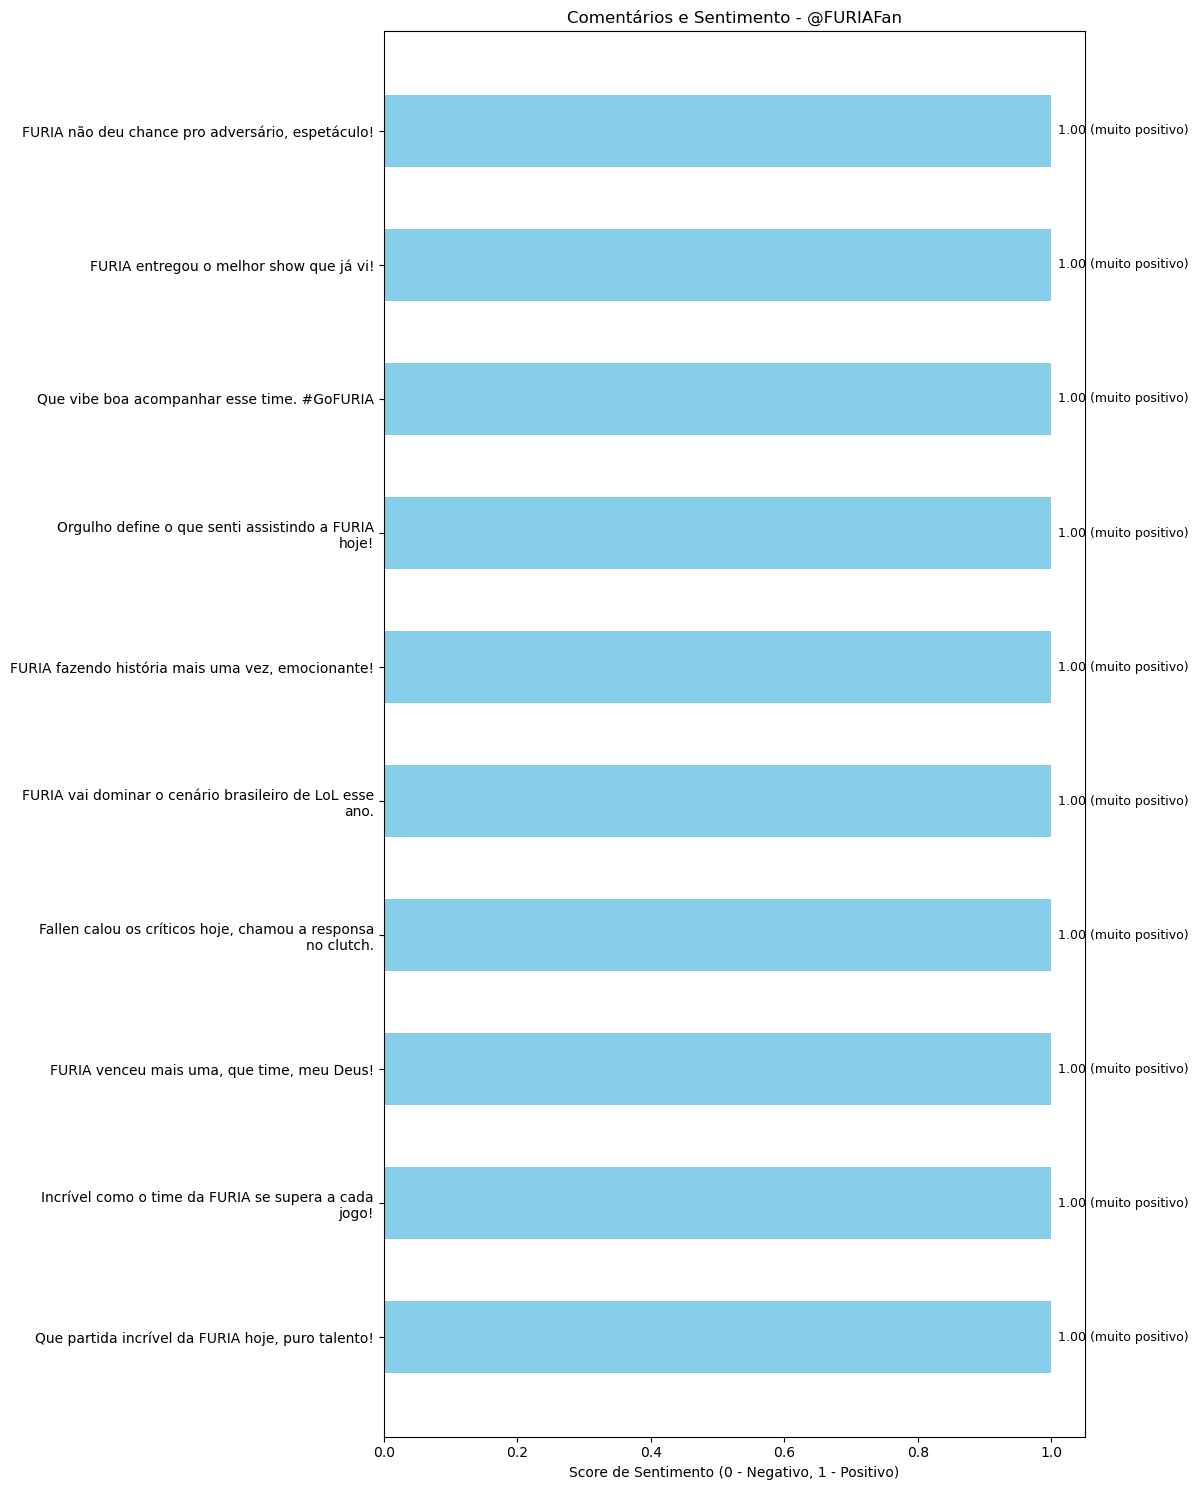

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap
import json
import random

# ====== 1. Carrega os dados JSON ======
with open(r'form_data/tweets_User.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# ====== 2. Elimina duplicatas baseado no texto ======
df = df.drop_duplicates(subset=['text'])

# ====== 3. Adiciona likes aleatórios para simulação ======
df['likes'] = [random.randint(1, 5000) for _ in range(len(df))]

# ====== 4. Filtra os 200 melhores por likes ======
top200 = df.sort_values('likes', ascending=False).head(200).copy()

# ====== 5. Remove palavras banidas ======
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']
top200_filtrado = top200[~top200['text'].str.upper().str.contains('|'.join(palavras_banidas))]

# ====== 6. Cria pipeline de análise de sentimento ======
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
)

# ====== 7. Aplica o modelo de análise de sentimento ======
batch_size = 32
top200_filtrado = top200_filtrado.reset_index(drop=True)
texts = top200_filtrado['text'].tolist()
results = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    results.extend(sentiment_analyzer(batch, truncation=True))

# ====== 8. Normaliza os scores de sentimento ======
scores = [(int(res['label'][0]) - 1) / 4 for res in results]
top200_filtrado['sentiment_score'] = scores

# ====== 9. Adiciona um campo "channel_name" ======
top200_filtrado['channel_name'] = top200_filtrado['author'].apply(lambda a: a['username'])

# ====== 10. Pega os top 10 comentários por canal ======
top_comentarios_canal = []
for canal, grupo in top200_filtrado.groupby('channel_name'):
    top_comentarios_canal.append(grupo.sort_values('sentiment_score', ascending=False).head(10))
top_comentarios_canal = pd.concat(top_comentarios_canal).reset_index(drop=True)

# ====== 11. Funções auxiliares ======
def simplificar_comentario(texto, limite=250):
    if len(texto) <= limite:
        return texto
    palavras = texto.split()
    return f"{texto[:limite].rstrip()}... {' '.join(palavras[-2:])}"


def estrela_para_sentimento(score):
    """
    Converte score normalizado (0-1) para sentimento textual em 1-5 estrelas.
    """
    stars = int(round(score * 4)) + 1
    if stars == 1:
        return "muito negativo"
    elif stars == 2:
        return "negativo"
    elif stars == 3:
        return "neutro"
    elif stars == 4:
        return "positivo"
    else:
        return "muito positivo"

# ====== 12. Função para gerar gráfico com sentimento ======
def plot_comentarios_canal(df, canal):
    comentarios = [textwrap.fill(simplificar_comentario(txt), width=50) for txt in df['text']]
    sentiment_scores = df['sentiment_score']
    
    spacing = 1.5
    y_positions = [i * spacing for i in range(len(comentarios))]

    plt.figure(figsize=(12, len(df) * 1.5))
    plt.barh(y_positions, sentiment_scores, color='skyblue')  # azul claro
    plt.yticks(y_positions, comentarios)
    plt.xlabel('Score de Sentimento (0 - Negativo, 1 - Positivo)')
    plt.title(f'Comentários e Sentimento - @{canal}')
    plt.gca().invert_yaxis()

    # Exibe o score de sentimento e texto do sentimento ao lado de cada barra
    for y, score in zip(y_positions, sentiment_scores):
        sentimento = estrela_para_sentimento(score)
        plt.text(score + 0.01, y, f'{score:.2f} ({sentimento})', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# ====== 13. Gera o gráfico para cada canal ======
for canal, grupo in top_comentarios_canal.groupby('channel_name'):
    plot_comentarios_canal(grupo, canal)


#### Frequência de Tweets (Intervalo de 3h)

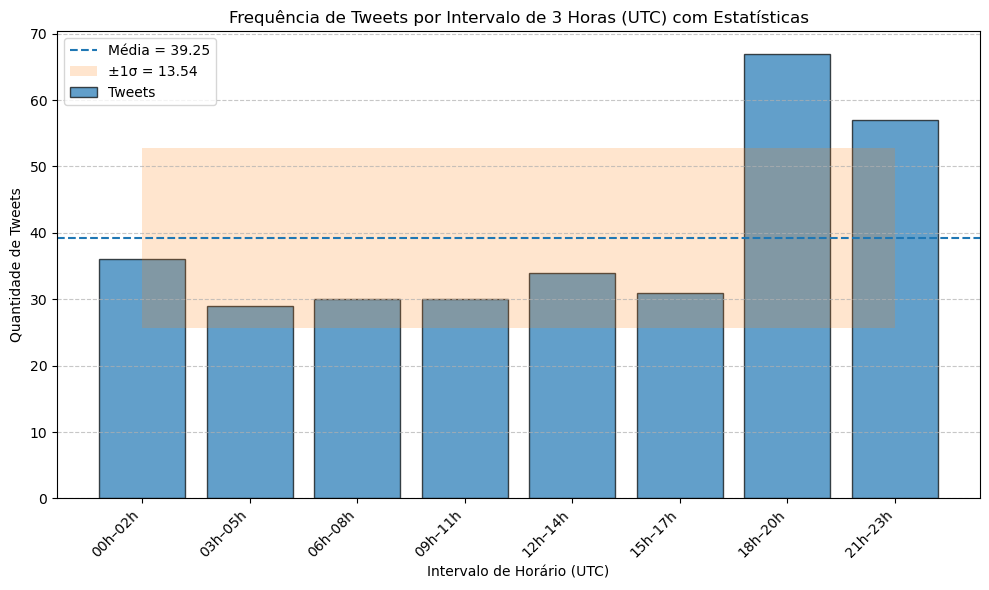

Frequência por bloco:
bloco_3h
00h–02h    36
03h–05h    29
06h–08h    30
09h–11h    30
12h–14h    34
15h–17h    31
18h–20h    67
21h–23h    57

Média = 39.25, σ = 13.54, Mediana = 32.50, Assimetria = 1.48


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import json

# ====== 1. Carrega todos os tweets do arquivo ======
with open('form_data/tweets_User.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
# Transforma em DataFrame
df = pd.DataFrame(data)

# ====== 2. Converte 'created_at' para datetime UTC e extrai hora ======
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df['hora_utc'] = df['created_at'].dt.hour

# ====== 3. Agrupa por blocos de 3 horas ======
df['bloco_3h'] = df['hora_utc'].apply(lambda h: f"{(h//3)*3:02d}h–{(h//3)*3+2:02d}h")
frequencia = df['bloco_3h'].value_counts().sort_index()
vals = frequencia.values

# ====== 4. Estatísticas ======
mu = vals.mean() if len(vals)>0 else 0
sigma = vals.std(ddof=0) if len(vals)>0 else 0
median = np.median(vals) if len(vals)>0 else 0
skewness = pd.Series(vals).skew() if len(vals)>0 else 0

# ====== 5. Plot com média e banda ±1σ ======
plt.figure(figsize=(10, 6))
plt.bar(frequencia.index, vals, edgecolor='black', alpha=0.7, label='Tweets')
plt.axhline(mu, linestyle='--', label=f'Média = {mu:.2f}')
if sigma > 0:
    x = np.arange(len(vals))
    plt.fill_between(x, mu-sigma, mu+sigma, alpha=0.2, label=f'±1σ = {sigma:.2f}')

plt.title('Frequência de Tweets por Intervalo de 3 Horas (UTC) com Estatísticas')
plt.xlabel('Intervalo de Horário (UTC)')
plt.ylabel('Quantidade de Tweets')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# ====== 6. Exibe estatísticas no console ======
print(f"Frequência por bloco:\n{frequencia.to_string()}\n")
print(f"Média = {mu:.2f}, σ = {sigma:.2f}, Mediana = {median:.2f}, Assimetria = {skewness:.2f}")

### Dashbord individual

In [7]:
import json
import os
import base64
from collections import Counter
import pandas as pd
import random
from transformers import pipeline
import dash
from dash import dcc, html
import plotly.express as px

# ====== 1. Configurações iniciais ======
DATA_DIR = 'form_data'

with open(os.path.join(DATA_DIR, 'last_user_id.json'), 'r', encoding='utf-8') as f:
    USER_ID = json.load(f)['last_user_id']
USER_JSON = os.path.join(DATA_DIR, f'{USER_ID}.json')
USER_IMAGE_PATH = os.path.join(DATA_DIR, f'{USER_ID}_selfie.png')
TWEETS_JSON = os.path.join(DATA_DIR, 'tweets_User.json')

# ====== 2. Carrega dados de usuário ======
with open(USER_JSON, 'r', encoding='utf-8') as f:
    user = json.load(f)

# ====== 2.1 Classificação de Produtos ======
COLLABS_KEYWORDS = ['Adidas', 'Batman', 'Champion', 'My Hero Academia', 'Zor', 'New Era']
COLECOES_KEYWORDS = ['Classic', 'Clutch', 'Furia', 'Future is Black', 'Hard To Love x Harder To Kill', 'Magic Panthera', 'Spray It']
produtos = user.get('produtos_furia', [])
collabs = [p for p in produtos if p in COLLABS_KEYWORDS]
colecoes = [p for p in produtos if p in COLECOES_KEYWORDS]
produtos_restantes = [p for p in produtos if p not in COLLABS_KEYWORDS + COLECOES_KEYWORDS]

# ====== 3. Carrega e processa tweets ======
df = pd.read_json(TWEETS_JSON)
df = df.drop_duplicates(subset=['text'])
gen = random.Random(42)
df['likes'] = [gen.randint(1, 5000) for _ in range(len(df))]
top = df.sort_values('likes', ascending=False).head(300)

# ====== 4. Análise de Sentimento ======
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    tokenizer='nlptown/bert-base-multilingual-uncased-sentiment'
)
results = sentiment_analyzer(top['text'].tolist(), truncation=True)
top['sentiment_score'] = [(int(r['label'][0]) - 1) / 4 for r in results]

def score_to_star(score):
    return int(round(score * 4)) + 1

top['stars'] = top['sentiment_score'].apply(score_to_star)

# ====== 5. Estatísticas de Texto ======
STOPWORDS = set([
    'a', 'o', 'as', 'os', 'e', 'é', 'de', 'do', 'da', 'dos', 'das', 'em', 'no', 'na', 'nos', 'nas',
    'um', 'uma', 'uns', 'umas', 'para', 'por', 'com', 'sem', 'que', 'qui', 'on', 'the', 'and', 'is', 'in', 'to', 'of', 'it', 'you', 'for', 'this'
])
word_counts = Counter()
for text in top['text']:
    for w in text.lower().split():
        w_clean = ''.join(ch for ch in w if ch.isalpha())
        if w_clean and w_clean not in STOPWORDS:
            word_counts[w_clean] += 1

top_words = word_counts.most_common(10)

# ====== 6. Geração de Gráficos ======
fig_sentiment = px.bar(
    x=top['stars'].value_counts().sort_index().index.astype(str) + '★',
    y=top['stars'].value_counts().sort_index().values,
    title='Distribuição de Sentimento por Estrelas',
    labels={'x': 'Estrelas', 'y': 'Contagem'},
    template='plotly_dark'
)

fig_words = px.bar(
    x=[w for w, _ in top_words],
    y=[cnt for _, cnt in top_words],
    title='Top 10 Palavras Mais Usadas',
    labels={'x': 'Palavra', 'y': 'Frequência'},
    template='plotly_dark'
)

# ====== 7. Frase mais positiva e Fã % ======
best_idx = top['sentiment_score'].idxmax()
best_phrase = top.loc[best_idx, 'text']
fan_pct = top['sentiment_score'].mean() * 100

# ====== 7.1 Define emoji conforme nível de fã ======
if fan_pct > 75:
    fan_emoji = '🖤'  # Pantera
elif fan_pct > 60:
    fan_emoji = '😊'  # feliz
elif fan_pct > 45:
    fan_emoji = '😐'  # sem emoção
elif fan_pct > 25:
    fan_emoji = '☹️'  # triste
else:
    fan_emoji = '😭'  # chorando

# ====== 8. Encode da Imagem ======
encoded_image = base64.b64encode(open(USER_IMAGE_PATH, 'rb').read()).decode()
IMAGE_SRC = f'data:image/png;base64,{encoded_image}'

# ====== 9. Monta App Dash ======
app = dash.Dash(__name__)
app.layout = html.Div(
    style={
        'backgroundColor': '#121212',
        'color': '#e0e0e0',
        'fontFamily': 'Inter, sans-serif',
        'padding': '20px'
    },
    children=[
        html.H1(
            'Dashboard Geral: Fã da FURIA',
            style={'textAlign': 'center', 'color': '#fff', 'fontFamily': 'Georgia, serif'}
        ),
        html.Div(
            style={'display': 'flex', 'gap': '20px'},
            children=[
                html.Div(
                    style={
                        'flex': '2',
                        'backgroundColor': '#1e1e1e',
                        'padding': '20px',
                        'borderRadius': '10px',
                        'boxShadow': '0 4px 15px rgba(0,0,0,0.2)'
                    },
                    children=[
                        html.Img(
                            src=IMAGE_SRC,
                            style={'width': '120px', 'borderRadius': '8px', 'marginBottom': '15px', 'display': 'block', 'margin': '0 auto'}
                        ),
                        html.Blockquote(
                            best_phrase,
                            style={
                                'borderLeft': '4px solid #4caf50',
                                'padding': '10px 15px',
                                'backgroundColor': '#2a2a2a',
                                'fontStyle': 'italic',
                                'fontFamily': 'Inter, sans-serif'
                            }
                        ),
                       html.P([
                            'Nome: ',
                            html.Span(user['nome'], style={'color': '#4caf50' if user.get('name_match') else '#888'})
                        ]),
                        html.P([
                            'Face match: ',
                            html.Span(
                                'Validado' if user.get('name_match') else 'Não verificado',
                                style={'color': '#4caf50' if user.get('name_match') else '#888'}
                            )
                        ]),
                        html.P([
                            'Naturalidade: ',
                            html.Span(
                                user.get('naturalidade_extraida') or '(não verificado)',
                                style={'color': '#4caf50' if user.get('naturalidade_extraida') else '#888'}
                            )
                        ]),

                        html.P(f'Porcentagem de fã: {fan_pct:.1f}% {fan_emoji}')
                    ]
                ),
                html.Div(
                    style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '20px', 'borderRadius': '10px', 'boxShadow': '0 4px 15px rgba(0,0,0,0.2)'},
                    children=[
                        html.H3('Interesses e Atividades', style={'fontFamily': 'Georgia, serif'}),
                        html.P('Jogos Favoritos: ' + ', '.join(user.get('jogos_furia', []))),
                        html.P('Produtos Comprados: ' + ', '.join(produtos_restantes)),
                        html.P('Collabs: ' + (', '.join(collabs) if collabs else 'Nenhum')),
                        html.P('Coleções: ' + (', '.join(colecoes) if colecoes else 'Nenhuma')),
                        html.P('Eventos: ' + user.get('eventos_furia', ''))
                    ]
                )
            ]
        ),
        html.Div(
            style={'display': 'flex', 'gap': '20px', 'marginTop': '30px'},
            children=[
                html.Div(dcc.Graph(figure=fig_words), style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '10px', 'borderRadius': '8px'}),
                html.Div(dcc.Graph(figure=fig_sentiment), style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '10px', 'borderRadius': '8px'})
            ]
        )
    ]
)

if __name__ == '__main__':
    app.run()


Device set to use cpu
